In [1]:
import pandas as pdw
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from math import sqrt
from matplotlib import pyplot
from numpy import array
import os
import numpy as np

PATH_TO_STOCKS = "./dataset/Stocks/"
SELECTED = "Open"

In [2]:
# date-time parsing function for loading the dataset
def parser(x):
    return pd.datetime.strptime(x, '%Y-%m-%d')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    print(X.shape)
    print(y.shape)
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=1)
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False, callbacks=[es])
#         model.reset_states()
        print(i)
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        print(actual)
        print(predicted)
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
        break
    return

In [3]:
# load dataset
data = pd.read_csv(os.path.join(PATH_TO_STOCKS, "gty.us.txt"), delimiter = ",", parse_dates=['Date'], usecols=[0,1,2,3,4], index_col=['Date'])
# data_train = data[:"2016"]
# data_test = data["2017"]

series = data[SELECTED]

In [4]:
# configure
n_seq = 30
n_test = 30
n_lag = len(series)-n_seq-n_test-200
n_epochs = 15
n_batch = 1
n_neurons = 50

In [5]:
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

In [6]:
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

(200, 2941)
(200, 30)
200/200 [==============================] - 2s 4ms/step - loss: 0.0082
0
200/200 [==============================] - 1s 4ms/step - loss: 0.0031
1
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
2
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
3
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
4
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
5
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
6
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
7
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
8
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
9
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
10
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
11
200/200 [==============================] - 1s 4ms/step - loss: 0.0030
12
200/200 [==============================

In [7]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

[28.57, 29.174, 28.442999999999998, 28.857, 28.92, 29.536, 28.547, 29.051, 29.246, 29.447, 29.398999999999997, 29.658, 29.777, 29.808999999999997, 29.648000000000003, 29.89, 29.274, 29.909000000000002, 29.727999999999998, 29.57, 29.189, 28.619999999999997, 28.43, 28.13, 27.870000000000005, 28.799999999999997, 28.15, 28.020000000000003, 28.249999999999996, 27.71]
[28.654967380166052, 28.625734469592572, 28.814208434224128, 28.7285207259655, 28.945407076179983, 29.303185029923917, 29.297427085042, 29.226649646759032, 28.956968226134777, 29.245351435244082, 29.404627775251864, 29.50428069740534, 29.625495454967023, 29.743462213873862, 29.625825903117658, 29.89558841586113, 29.857168393433096, 29.857498163580896, 29.688977379500866, 29.598435565829277, 29.20968441724777, 28.616627600491046, 28.17426899254322, 28.32562437981367, 28.194514459371568, 28.585051184296606, 28.34340827167034, 28.145011316239835, 28.159355831742285, 27.894659492373467]
t+1 RMSE: 0.257075


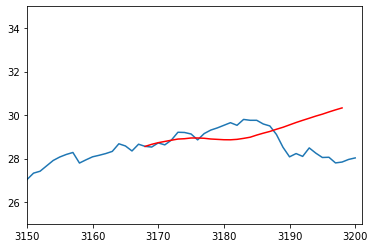

In [8]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
        break # lazy fix so only one prediction is plotted
    # show the plot
    pyplot.axis([3150, len(series), 25, 35])
    pyplot.savefig("lstm_plot.png")
    pyplot.show()
    return

# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

# plot forecasts
plot_forecasts(series, forecasts, n_test+2)